In [1]:
import torch
import os
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

class Trainer:
    def __init__(self, lr = 0.00003, batch_size = 16):
        self.lr = lr
        self.batch = batch_size
        self.val_loss = float('inf')
        
    def fit_epoch(self, model, train_loader, criterion, optimizer):
        running_loss = 0.0
        processed_data = 0
  
        for inputs, targets in tqdm(train_loader):
            inputs = inputs.to(DEVICE).float()
  
            targets = targets.to(DEVICE).float()
            optimizer.zero_grad()




            outputs = model(inputs)['out'].float()
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) 
            processed_data += inputs.size(0)
        train_loss = running_loss / processed_data
        return train_loss
        
    def eval_epoch(self, model, val_loader, criterion):
        model.eval()
        running_loss = 0.0
        
        processed_size = 0

        for inputs, targets in val_loader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE).float()

            with torch.set_grad_enabled(False):
                outputs =model(inputs)['out'].float()
                loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            processed_size += inputs.size(0)
        val_loss = running_loss / processed_size 
        return val_loss
        
    def train(self, model, epochs, train_dataset,val_dataset,  loss_func):
        
        train_dataset = train_dataset
        train_dataloader = DataLoader(train_dataset, batch_size= self.batch, shuffle=False)
        val_dataset = val_dataset
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch, shuffle=False)
        
        model = model
        
        criterion = loss_func
        
        optimizer = torch.optim.Adam(model.parameters(), lr = self.lr)
        self.optimizer = optimizer
        
        tr_loss = []
        v_loss = []

        for epoch in range(epochs):
            train_loss = self.fit_epoch(model, train_dataloader, criterion, optimizer)
            tr_loss.append(train_loss)
            print("train_loss= ", train_loss)

            val_loss = self.eval_epoch(model, val_dataloader, criterion)
            v_loss.append(val_loss)
            print("val_loss= ", val_loss, "\n")
            
            if self.val_loss > val_loss:
                torch.save(model.state_dict(), "gdrive/MyDrive/best_model_p.pth")
                torch.save(optimizer.state_dict(), "gdrive/MyDrive/best_optimizer.pth")
                self.val_loss = val_loss

        plt.figure(figsize=(15, 9))
        plt.plot(tr_loss, label="train_loss")
        plt.plot(v_loss, label="val_loss")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()
    

cpu


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
from typing import Tuple
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch
import numpy as np
import os
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

class Data(Dataset):
    def __init__(self, files, coco_dataset):
        # Initialize dataset, you may use a second dataset for validation if required
        # Use the input transform to convert images to grayscale
        self.files = files
        self.len_ = len(self.files)
        self.coco_dataset = coco_dataset
        self.input_transform = T.Compose([T.ToTensor(),
                                          T.Resize(size=(256,256))
                                          ])
        # Use this on target images(colorful ones)
        
    
    def __len__(self) -> int:
        # return Length of dataset
        return len(self.files)
    
    def load_sample(self, file):
        image = io.imread(file)
        return image
    
    
    def __getitem__(self, index) :
        # Return the input tensor and output tensor for training
        image = self.input_transform(self.load_sample(self.files[index]['coco_url']))
        mask = np.zeros((self.files[index]['height'],self.files[index]['width']))
        annIds = self.coco_dataset.getAnnIds(imgIds=self.files[index]['id'], catIds=catIds, iscrowd=None)
        anns = self.coco_dataset.loadAnns(annIds)
        for i in range(len(anns)):
            mask = np.maximum(self.coco_dataset.annToMask(anns[i]), mask)
        return image, self.input_transform(mask)

Загрузка данных будет проходить через ссылку в файлах annotations.

In [4]:
#!wget http://images.cocodataset.org/zips/train2017.zip

In [5]:
#!unzip -q train2017.zip

In [6]:
#!wget http://images.cocodataset.org/zips/val2017.zip

In [7]:
#!unzip -q val2017.zip

In [8]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip


--2022-05-05 08:21:27--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.96.148
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.96.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.2MB/s    in 2.5s    

2022-05-05 08:21:29 (96.2 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [9]:
!unzip -q annotations_trainval2017.zip

In [10]:
#!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip

In [11]:
#!unzip -q stuff_annotations_trainval2017.zip

In [12]:
coco_train=COCO('annotations/instances_train2017.json')

loading annotations into memory...
Done (t=19.95s)
creating index...
index created!


In [13]:
coco_val=COCO('annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


Посмотрим на изображения

In [14]:
catIds = coco_train.getCatIds(catNms=['__background__'])
imgIds = coco_train.getImgIds(catIds=catIds )

catIds_val = coco_val.getCatIds(catNms=['__background__'])
imgIds_val = coco_val.getImgIds(catIds=catIds_val )

#imgIds = coco_train.getImgIds()
train = coco_train.loadImgs(imgIds)
val = coco_val.loadImgs(imgIds_val)

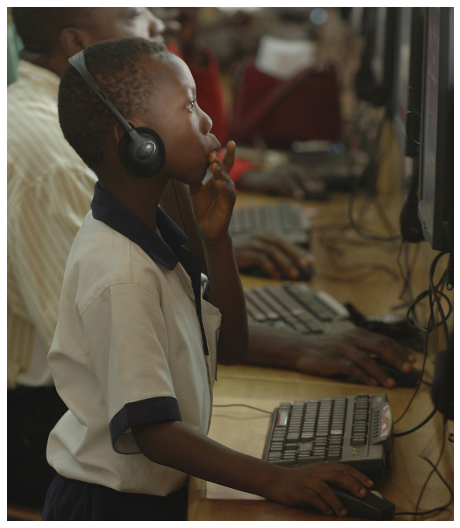

In [15]:
I = io.imread(train[3]['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

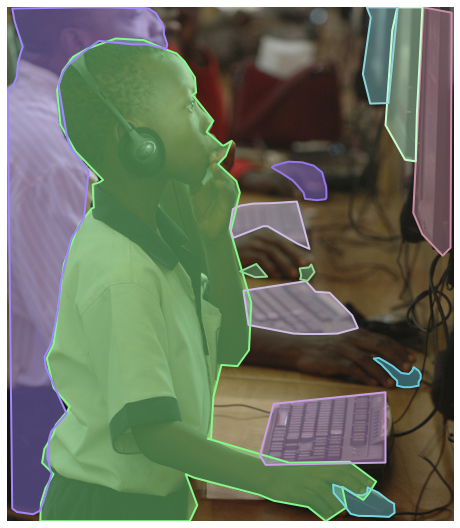

In [16]:
plt.imshow(I); plt.axis('off')
annIds = coco_train.getAnnIds(imgIds=train[3]['id'], catIds=catIds, iscrowd=None)
anns = coco_train.loadAnns(annIds)
coco_train.showAnns(anns)


In [17]:
annIds = coco_train.getAnnIds(imgIds=imgIds, catIds=catIds, iscrowd=None)
anns = coco_train.loadAnns(annIds)
annIDs_val = coco_val.getAnnIds(imgIds=imgIds_val, catIds=catIds_val, iscrowd=None)
anns_val = coco_val.loadAnns(annIDs_val)

In [18]:
len(train)

118287

In [19]:
len(anns_val)

36781

Будем тренироваться на изображениях  с достаточно большим размером сегментированного участка

In [20]:
anns2 = [ann for ann in anns if ann['area']>70000]
anns2_val = [ann for ann in anns_val]

In [21]:
q = set(ann['id'] for ann in anns2)
q1 = set(ann['id'] for ann in anns2_val)

In [22]:
len(q1)

36781

In [23]:
train1 = [pic for pic in train if pic['id'] in q]
val1 = [pic for pic in val if pic['id'] in q1]

In [24]:
len(train1)

4331

In [25]:
val1 = val[:100]

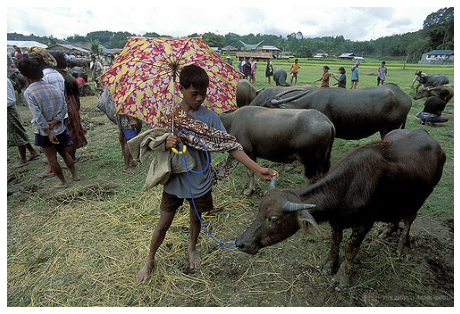

In [26]:
I1 = io.imread(train1[0]['coco_url'])
plt.axis('off')
plt.imshow(I1)
plt.show()

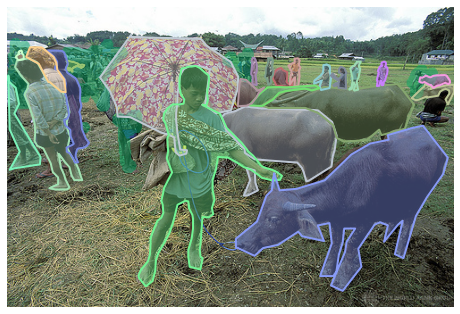

In [27]:
plt.imshow(I1); plt.axis('off')
annIds = coco_train.getAnnIds(imgIds=train1[0]['id'], catIds=catIds, iscrowd=None)
anns = coco_train.loadAnns(annIds)
coco_train.showAnns(anns)


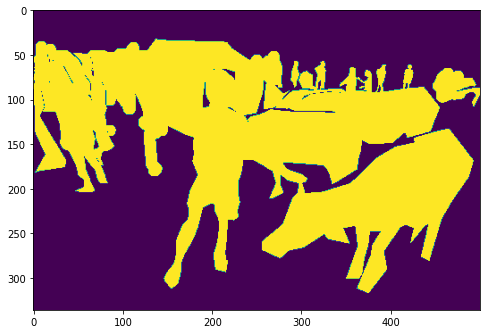

In [28]:
mask = np.zeros((train1[0]['height'],train1[0]['width']))
for i in range(len(anns)):
    mask = np.maximum(coco_train.annToMask(anns[i]), mask)
plt.imshow(mask)

Воспользуемся предобученной моделью fcn_resnet50, тренированную на coco датасете

In [57]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [30]:
model1 = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Ниже определена функция, получающая на вход модель и ссылку на изображение и возвращающая изображение с удаленным фоном

In [31]:
def inference(model, url):
  I1 = io.imread(url)
  tensor = torch.from_numpy(I1).unsqueeze(dim = 0).permute(0, 3,1,2).float()
  with torch.no_grad():
    output = model(tensor)['out'][0]
  output_predictions = output.argmax(0)
  ones = np.ones(output_predictions.byte().numpy().shape, dtype = int)
  zeros = np.zeros(output_predictions.byte().numpy().shape, dtype = int)
  mask = np.where(output_predictions.byte().numpy() > 0, ones,zeros )
  mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask2 = np.concatenate((mask,mask,mask), 2)
  I2 = mask2 * I1

  plt.imshow(I2)

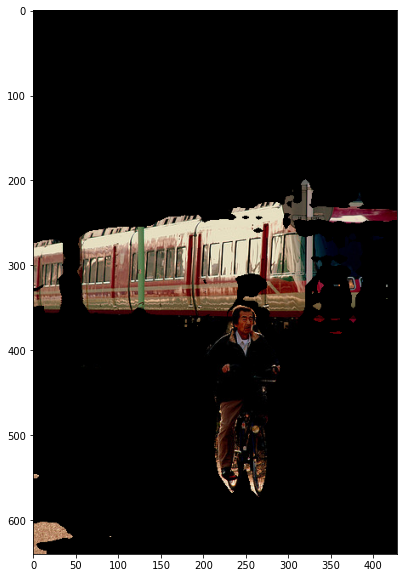

In [32]:
inference(model,train[13]['coco_url'])

In [33]:
train_dataset = Data(train1, coco_train)

In [34]:
val_dataset = Data(val1, coco_val)

In [36]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded 

In [37]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        threshold = 0.35
        print(len(data))
        for X_batch, Y_label in data:
            #print('scoring')
            Y_pred = model(X_batch.to(DEVICE))['out'].to('cpu').detach()
          
            #Y_pred = torch.from_numpy(predict(model, X_batch)).to(device)
            #print (Y_pred)
            Y_pred = torch.where(Y_pred > threshold, 1, 0)
            scores += metric(Y_pred.to(DEVICE), Y_label.to(DEVICE)).mean().item()

    return scores/len(data)

In [38]:
criterion = torch.nn.BCELoss()
trainer = Trainer()

In [39]:
model.classifier = nn.Sequential(
   nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
   nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
   nn.ReLU(),
   nn.Dropout(p=0.1, inplace=False),
   nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1)),
   nn.Sigmoid()
)

Возьмем для тестового датасета 150 изображений из трейна и исключим их из последнего

In [40]:
indexes = []
for ind, pic in enumerate(train1):
  img = io.imread(pic['coco_url'])
  if len(img.shape) == 3 and img.shape[2] == 3:
    indexes.append(ind)


In [41]:
train1 = np.array(train1)

In [42]:
train1 = train1[indexes]

In [43]:
test = train1[:150]

In [44]:
train1 = train1[150:]

In [45]:
train_dataset = Data(train1, coco_train)


In [46]:
test_dataset = Data(test, coco_train)

In [47]:
import json

In [48]:
train2 = list(train1)

In [ ]:
with open('gdrive/MyDrive/array.json', 'w') as f:
    json.dump( train2, f)

In [ ]:
for param in model1.parameters():
    param.requires_grad = False

In [ ]:
model1.classifier = nn.Sequential(
   nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
   nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
   nn.ReLU(),
   nn.Dropout(p=0.1, inplace=False),
   nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1)),
   nn.Sigmoid()
)

In [ ]:
model1 = model1.cuda()

In [ ]:
trainer.train(model1,  1, train_dataset, val_dataset,  criterion)

100%|██████████| 271/271 [20:50<00:00,  4.62s/it]


train_loss=  0.27751519745683484
val_loss=  0.2995763146877289 



100%|██████████| 271/271 [20:44<00:00,  4.59s/it]


train_loss=  0.26635797300760294
val_loss=  0.2724080741405487 



100%|██████████| 271/271 [20:15<00:00,  4.48s/it]


train_loss=  0.256355209997257
val_loss=  0.2695386826992035 



100%|██████████| 271/271 [20:19<00:00,  4.50s/it]


train_loss=  0.2507932529601751
val_loss=  0.26909707188606263 



 28%|██▊       | 77/271 [05:49<14:40,  4.54s/it]

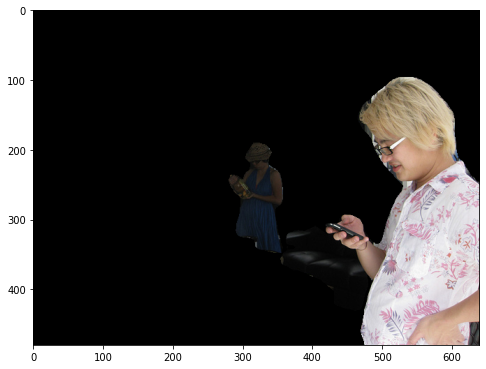

In [59]:
inference(model,test[27]['coco_url'])

In [60]:
train_dataloader = DataLoader(train_dataset, batch_size= 16, shuffle=False)
val_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)